In [52]:
import pandas as pd
import numpy as np
import scipy as sp
import string
import random
import re
import collections
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import welch, hanning

In [2]:
labels = pd.read_csv('Data/20190819_WPS_NORM.hackathon_sample_info_updated.csv')
labels = labels.fillna('N/A')
labels.rename(columns={'library':'PatientId', 'hotspot':'Oncogene'},inplace=True)

In [3]:
zeroPurity = labels[(labels['estimated.purity']==0) & (labels['ctdna.score']<=0.01)]

In [4]:
highPurity = labels[labels['estimated.purity']>=0.6]

In [5]:
print('Number of patient samples:',labels['PatientId'].unique().shape[0])
if (labels['PatientId'].unique().shape[0] != labels['PatientId'].shape[0]):
    print('Warning! Repeated patient IDs')

Number of patient samples: 1764


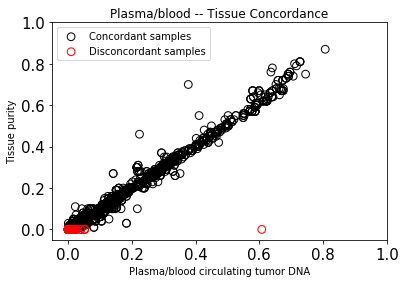

In [67]:
# Plasma/blood -- tissue concordance
n = len(labels);
ind = np.random.randint(len(labels), size=n)
sample_ctdna = labels['ctdna.score'][ind]
sample_purity = labels['estimated.purity'][ind]
disc_ind = (sample_purity==0) | (sample_ctdna==0.0);
a = plt.scatter(sample_ctdna[~disc_ind],sample_purity[~disc_ind],s=60,marker='o',color='k',facecolors='none')
b = plt.scatter(sample_ctdna[disc_ind],sample_purity[disc_ind],s=60,marker='o',color='r',facecolors='none')
plt.title('Plasma/blood -- Tissue Concordance')
plt.ylabel('Tissue purity')
plt.xlabel('Plasma/blood circulating tumor DNA')
plt.legend([a,b],['Concordant samples','Disconcordant samples'])
plt.ylim((-0.05,1))
plt.xlim((-0.05,1))
plt.show()

In [7]:
# Perform pairs bootstrap for linear regression
def draw_bs_pairs_linreg(x, y, size=1):
    inds = np.arange(0,len(x))

    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x,bs_y,1)

    return bs_slope_reps, bs_intercept_reps

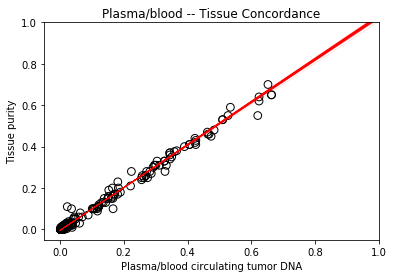

In [8]:
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(labels['ctdna.score'].values,labels['estimated.purity'].values,1000)
x = np.array([0,1])

# Plot the bootstrap lines
for i in range(100):
    _ = plt.plot(x, 
                 bs_slope_reps[i]*x + bs_intercept_reps[i],
                 linewidth=0.5, alpha=0.2, color='red')
    
_ = plt.scatter(sample_ctdna,sample_purity,s=60,marker='o',color='k',facecolors='none')
plt.title('Plasma/blood -- Tissue Concordance')
plt.ylabel('Tissue purity')
plt.xlabel('Plasma/blood circulating tumor DNA')
plt.ylim((-0.05,1))
plt.xlim((-0.05,1))
plt.show()

In [9]:
# 95% confidence interval for the slope
print(np.percentile(bs_slope_reps, [2.5,97.5]))

[1.01804367 1.04310473]


In [10]:
data = pd.read_csv('Data/example_WPS_NORM.exons.collapsed.csv',sep='\t',header=None)
# 0: sample id (patient id)
# 1: chromosome
# 2: start of exon
# 3: end of exon e.g row 0 has 65 30 basepairs
# 4: (30 basepairs) - window protection score as defined in Snyder2016 paper normalized
# gene_id: roughly 600 genes per patient
# Data to be provided purity per sample: fraction of cancer cells detected in circulation (low purity: healthy cells)

In [11]:
data.head(10)

,0,1,2,3,4,5,6
0,LIB-ZIIEJE,chr1,3598930,3598995,"-0.735294,-0.735294,-0.735294,-0.735294,-0.735...",+,"gene_id ""ENSG00000078900.10""; transcript_id ""E..."
1,LIB-ZIIEJE,chr1,3599624,3599745,"-0.780822,-0.780822,-0.780822,-0.780822,-0.726...",+,"gene_id ""ENSG00000078900.10""; transcript_id ""E..."
2,LIB-ZIIEJE,chr1,3624113,3624356,"-0.988372,-0.977011,-0.988372,-0.977011,-1.011...",+,"gene_id ""ENSG00000078900.10""; transcript_id ""E..."
3,LIB-ZIIEJE,chr1,3624140,3624356,"-1.360465,-1.364706,-1.364706,-1.376471,-1.348...",+,"gene_id ""ENSG00000078900.10""; transcript_id ""E..."
4,LIB-ZIIEJE,chr1,3638585,3638772,"-1.100000,-1.083333,-1.024000,-1.015873,-0.968...",+,"gene_id ""ENSG00000078900.10""; transcript_id ""E..."
5,LIB-ZIIEJE,chr1,3639918,3640034,"-0.550000,-0.524752,-0.490000,-0.470000,-0.550...",+,"gene_id ""ENSG00000078900.10""; transcript_id ""E..."
6,LIB-ZIIEJE,chr1,3643679,3643789,"-0.823529,-0.768116,-0.753623,-0.753623,-0.775...",+,"gene_id ""ENSG00000078900.10""; transcript_id ""E..."
7,LIB-ZIIEJE,chr1,3644192,3644335,"-0.974359,-1.000000,-1.000000,-0.974359,-0.975...",+,"gene_id ""ENSG00000078900.10""; transcript_id ""E..."
8,LIB-ZIIEJE,chr1,3644693,3644782,"-1.628571,-1.540541,-1.540541,-1.447368,-1.447...",+,"gene_id ""ENSG00000078900.10""; transcript_id ""E..."
9,LIB-ZIIEJE,chr1,3645891,3646013,"-0.978261,-1.065217,-1.000000,-1.021277,-0.938...",+,"gene_id ""ENSG00000078900.10""; transcript_id ""E..."


In [12]:
def organize_column(l):
    if not pd.isnull(l): 
        l = l.replace('"', '')
        if l.split(";")[-1] in ['',' h']:
            l_d = dict(item.split() for item in l.split(";")[:-1])
        else:
            l_d = dict(item.split() for item in l.split(";"))
    else:
        l_d = np.nan

    return l_d

data['col'] = data[6].apply(lambda row : organize_column(row) )
df_pol_ps = data['col'].apply(pd.Series)
df_final = pd.concat([data, df_pol_ps], axis = 1)

del df_final[6] # remove column with geneid
del df_final['col']
del df_final[5] # remove column with + sign
df_final = df_final.drop(df_final.index[len(df_final)-1])
df_final.rename(columns={0:'PatientId', 1:'Chromosome', 2:'ExonStart', 3:'ExonEnd', 
                               4:'WPS'},inplace=True)
df_final = df_final.iloc[:, :-1] 

In [13]:
df_final.head(10)

,PatientId,Chromosome,ExonStart,ExonEnd,WPS,ccdsid,exon_id,exon_number,gene_id,gene_name,...,gene_type,havana_gene,havana_transcript,level,protein_id,tag,transcript_id,transcript_name,transcript_status,transcript_type
0,LIB-ZIIEJE,chr1,3598930,3598995,"-0.735294,-0.735294,-0.735294,-0.735294,-0.735...",CCDS49.1,ENSE00000868857.1,2,ENSG00000078900.10,TP73,...,protein_coding,OTTHUMG00000000610.5,OTTHUMT00000001468.4,2,ENSP00000367545.4,CCDS,ENST00000378295.4,TP73-001,KNOWN,protein_coding
1,LIB-ZIIEJE,chr1,3599624,3599745,"-0.780822,-0.780822,-0.780822,-0.780822,-0.726...",CCDS49.1,ENSE00000358575.1,3,ENSG00000078900.10,TP73,...,protein_coding,OTTHUMG00000000610.5,OTTHUMT00000001468.4,2,ENSP00000367545.4,CCDS,ENST00000378295.4,TP73-001,KNOWN,protein_coding
2,LIB-ZIIEJE,chr1,3624113,3624356,"-0.988372,-0.977011,-0.988372,-0.977011,-1.011...",CCDS49.1,ENSE00003496607.1,4,ENSG00000078900.10,TP73,...,protein_coding,OTTHUMG00000000610.5,OTTHUMT00000001468.4,2,ENSP00000367545.4,CCDS,ENST00000378295.4,TP73-001,KNOWN,protein_coding
3,LIB-ZIIEJE,chr1,3624140,3624356,"-1.360465,-1.364706,-1.364706,-1.376471,-1.348...",CCDS49.1,ENSE00003496607.1,4,ENSG00000078900.10,TP73,...,protein_coding,OTTHUMG00000000610.5,OTTHUMT00000001468.4,2,ENSP00000367545.4,CCDS,ENST00000378295.4,TP73-001,KNOWN,protein_coding
4,LIB-ZIIEJE,chr1,3638585,3638772,"-1.100000,-1.083333,-1.024000,-1.015873,-0.968...",CCDS49.1,ENSE00003670865.1,5,ENSG00000078900.10,TP73,...,protein_coding,OTTHUMG00000000610.5,OTTHUMT00000001468.4,2,ENSP00000367545.4,CCDS,ENST00000378295.4,TP73-001,KNOWN,protein_coding
5,LIB-ZIIEJE,chr1,3639918,3640034,"-0.550000,-0.524752,-0.490000,-0.470000,-0.550...",CCDS49.1,ENSE00003526787.1,6,ENSG00000078900.10,TP73,...,protein_coding,OTTHUMG00000000610.5,OTTHUMT00000001468.4,2,ENSP00000367545.4,CCDS,ENST00000378295.4,TP73-001,KNOWN,protein_coding
6,LIB-ZIIEJE,chr1,3643679,3643789,"-0.823529,-0.768116,-0.753623,-0.753623,-0.775...",CCDS49.1,ENSE00003646577.1,7,ENSG00000078900.10,TP73,...,protein_coding,OTTHUMG00000000610.5,OTTHUMT00000001468.4,2,ENSP00000367545.4,CCDS,ENST00000378295.4,TP73-001,KNOWN,protein_coding
7,LIB-ZIIEJE,chr1,3644192,3644335,"-0.974359,-1.000000,-1.000000,-0.974359,-0.975...",CCDS49.1,ENSE00003503102.1,8,ENSG00000078900.10,TP73,...,protein_coding,OTTHUMG00000000610.5,OTTHUMT00000001468.4,2,ENSP00000367545.4,CCDS,ENST00000378295.4,TP73-001,KNOWN,protein_coding
8,LIB-ZIIEJE,chr1,3644693,3644782,"-1.628571,-1.540541,-1.540541,-1.447368,-1.447...",CCDS49.1,ENSE00003651642.1,9,ENSG00000078900.10,TP73,...,protein_coding,OTTHUMG00000000610.5,OTTHUMT00000001468.4,2,ENSP00000367545.4,CCDS,ENST00000378295.4,TP73-001,KNOWN,protein_coding
9,LIB-ZIIEJE,chr1,3645891,3646013,"-0.978261,-1.065217,-1.000000,-1.021277,-0.938...",CCDS49.1,ENSE00003693819.1,10,ENSG00000078900.10,TP73,...,protein_coding,OTTHUMG00000000610.5,OTTHUMT00000001468.4,2,ENSP00000367545.4,CCDS,ENST00000378295.4,TP73-001,KNOWN,protein_coding


In [14]:
df_final['PatientId'].unique()

array(['LIB-ZIIEJE'], dtype=object)

In [15]:
def len_wps(x):
    return len(x.split(','))

In [16]:
data['WPS Length']= df_final['WPS'].apply(lambda row : len_wps(row) )

In [17]:
def frag_profile(x):
    p = x.replace("\'", "").split(',')
    results = list(map(float, p))
    return results

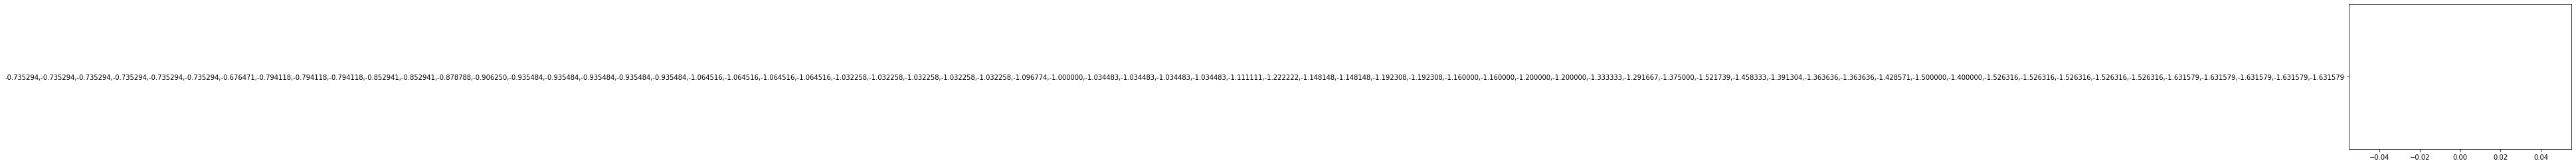

In [18]:
fragmentprofile = df_final['WPS'].apply(lambda row : frag_profile(row))
for i in range(0,1):
    plt.plot(df_final['WPS'][i])
    plt.show

In [19]:
chr1 = df_final[df_final['Chromosome']=='chr1']['WPS'].values

In [20]:
z = np.array([])
for i in range(0,len(chr1)):
    z = np.concatenate((z,frag_profile(chr1[i])),axis=0)

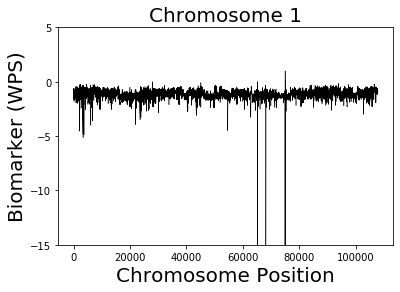

In [59]:
plt.plot(z,'-k',linewidth=0.5)
plt.title('Chromosome 1',fontsize=20)
plt.xlabel('Chromosome Position',fontsize=20)
plt.ylabel('Biomarker (WPS)',fontsize=20)
plt.ylim((-15,5))
matplotlib.rc('xtick',labelsize=15)
matplotlib.rc('ytick',labelsize=15)
plt.show()

In [22]:
example_patientid = df_final['PatientId'].astype('string').unique()
example_ind = labels[labels['PatientId'].str.match(example_patientid[0])].index
example_purity = labels['estimated.purity'][example_ind.array[0]]
example_ctdna = labels['ctdna.score'][example_ind.array[0]]

In [23]:
print('For example patient ID %s -- the tissue purity is %s and circulating tumor DNA score is %s\n' % (example_patientid[0],example_purity,example_ctdna))

For example patient ID LIB-ZIIEJE -- the tissue purity is 0.87 and circulating tumor DNA score is 0.8065899648999999



In [24]:
a = df_final.groupby('Chromosome')['WPS'].apply(','.join).reset_index()

In [25]:
def chr_profile(x):
    p = x.split(',')
    results = list(map(float, p))
    return results

In [26]:
chrprofile = a['WPS'].apply(lambda row : frag_profile(row))

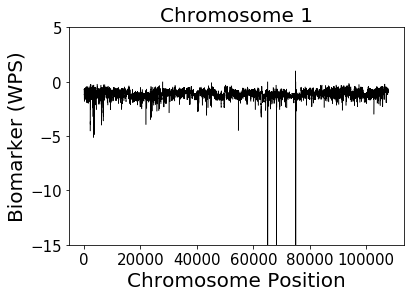

In [60]:
plt.plot(chrprofile[0],'-k',linewidth=0.5)
plt.title('Chromosome 1',fontsize=20)
plt.xlabel('Chromosome Position',fontsize=20)
plt.ylabel('Biomarker (WPS)',fontsize=20)
plt.ylim((-15,5))
matplotlib.rc('xtick',labelsize=15)
matplotlib.rc('ytick',labelsize=15)
plt.show()

In [28]:
##########################
# Testing out some metrics
##########################

In [29]:
test = chrprofile[0]

In [30]:
autocorr_test = np.correlate(test, test, mode='full')[len(test)-1:]

In [31]:
from scipy.signal import find_peaks
peaks_autocorr, _ = find_peaks(autocorr_test, height=0)

In [32]:
print('Second peak at index %s with max value of %s' % (peaks_autocorr[0],autocorr_test[peaks_autocorr[0]]))

Second peak at index 98 with max value of 563875.7072891564


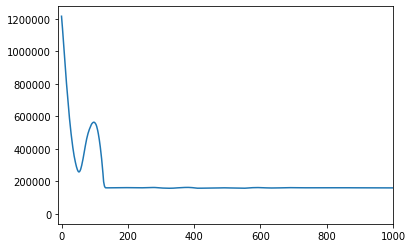

In [33]:
plt.plot(autocorr_test);
plt.plot
plt.xlim([-10,1000]);

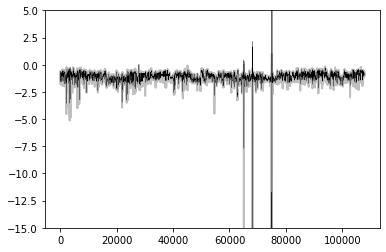

In [34]:
from scipy import signal
plt.plot(test,'0.75',linewidth=2);
plt.ylim(-15,5)
plt.plot(signal.savgol_filter(test,101,2),'-k',linewidth=0.25)

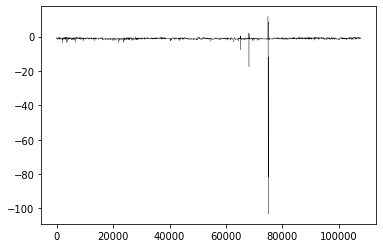

In [35]:
plt.plot(signal.savgol_filter(test,101,2),'-k',linewidth=0.25)

In [36]:
def modified_z_score(intensity):
    median_int = np.median(intensity)
    mad_int = np.median([np.abs(intensity - median_int)])
    modified_z_scores = 0.6745 * (intensity - median_int) / mad_int
    return modified_z_scores

In [37]:
def fixer(y,m):
    threshold = 7 # binarization threshold
    spikes = abs(np.array(modified_z_score(np.diff(y)))) > threshold
    y_out = y.copy() # So we don’t overwrite y
    for i in np.arange(len(spikes)):
        if spikes[i] != 0: # If we have an spike in position i
            w = np.arange(i-m,i+1+m) # we select 2 m + 1 points around our spike
            w2 = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
            y_w2 = list(y[i] for i in w2)
            y_out[i] = np.mean(y_w2) # and we average their values
    return y_out

/Users/anamaria1/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/anamaria1/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


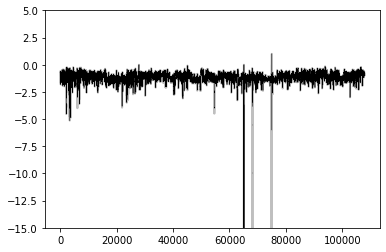

In [38]:
plt.plot(test,'0.75',linewidth=2);
plt.ylim(-15,5)
plt.plot(fixer(test,m=1),'-k',linewidth=0.5)

In [39]:
from scipy import signal
import pywt

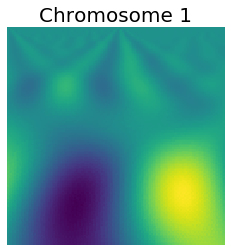

In [61]:
j = 0
test = chrprofile[j]
scales = range(1,128)
waveletname = 'morl'
coeff, freq = pywt.cwt(test, scales, waveletname, 1)
coeff_ = coeff[:,:127]
plt.imshow(coeff_)
plt.title('Chromosome %s'%(j+1),fontsize=20)
plt.axis('off');

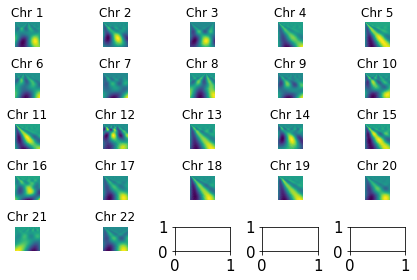

In [63]:
import math 
fig, axs = plt.subplots(5,5)
#fig.suptitle('Individual patient sample')
scales = range(1,128)
waveletname = 'morl'
for j in range(0,22):
    j_row = math.floor(j/5)
    j_col = j%5
    #print(j,j_row,j_col)
    coeff, freq = pywt.cwt(chrprofile[j], scales, waveletname, 1)
    coeff_ = coeff[:,:127]
    axs[j_row,j_col].imshow(coeff_)
    axs[j_row,j_col].set_title('Chr %s'%(j+1))
    axs[j_row,j_col].axis('off');
    
fig.tight_layout()
#plt.savefig('SamplePatient_CWT_PerChromosome.eps', bbox_inches='tight')
plt.show()

In [42]:
####################################################################################
####################################################################################
####################################################################################